# Clone the repository and install dependencies


In [1]:
# Clone the main repo
PHALP_ROOT="PHALP"
! git clone https://github.com/brjathu/PHALP.git $PHALP_ROOT
%cd PHALP

# # Install dependencies
!pip install -e .[all]

Cloning into 'PHALP'...
remote: Enumerating objects: 773, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 773 (delta 71), reused 57 (delta 57), pack-reused 684
Receiving objects: 100% (773/773), 125.53 MiB | 36.04 MiB/s, done.
Resolving deltas: 100% (404/404), done.
/content/PHALP
Obtaining file:///content/PHALP
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-install-jpbt80tg/detectron2_011ab16a2a784f3a9aa23c6a8e0f6913
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-install-jpbt80tg/detectron2_011ab16a2a784f3a9aa23c6a8e0f6913
  Resolved https://github.com/facebookresearch/detectron2.git to commit 017abbfa5f2c2a2afa045200c2af9ccf2fc6227f
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/pytube/pytube.git to /tmp/pip-install-jpbt80tg/pytube_0a52a22852e7480eb57ebb64bd886a4

# Run the demo

In [2]:
# # Use this for debugging, this will open up a terminal.
# !pip install colab-xterm
# %load_ext colabxterm
# %xterm

In [3]:
!wget https://github.com/classner/up/raw/master/models/3D/basicModel_neutral_lbs_10_207_0_v1.0.0.pkl
!mkdir data/
!mv basicModel_neutral_lbs_10_207_0_v1.0.0.pkl data/
!python scripts/demo.py video.source=assets/videos/vid.mp4

--2023-11-13 11:59:19--  https://github.com/classner/up/raw/master/models/3D/basicModel_neutral_lbs_10_207_0_v1.0.0.pkl
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/classner/up/master/models/3D/basicModel_neutral_lbs_10_207_0_v1.0.0.pkl [following]
--2023-11-13 11:59:19--  https://raw.githubusercontent.com/classner/up/master/models/3D/basicModel_neutral_lbs_10_207_0_v1.0.0.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39001280 (37M) [application/octet-stream]
Saving to: ‘basicModel_neutral_lbs_10_207_0_v1.0.0.pkl’

basicModel_neutral_ 100%[===================>]  37.19M   180MB/s    in 0

# Visualize the video

In [4]:
# Display the reconstruction video
def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                      <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))

!ffmpeg -y -hide_banner -loglevel error -i outputs/PHALP_vid.mp4 outputs/PHALP_vid_ffmpg.mp4
show_local_mp4_video('outputs/PHALP_vid_ffmpg.mp4', width=960, height=540)

In [5]:
import joblib
results = joblib.load("outputs/results/demo_vid.pkl")

In [37]:
import numpy as np

number_of_frames = len(results)

l2_distances = np.zeros(number_of_frames)  # Array to hold L2 distance for each frame
left_ankles = np.zeros((number_of_frames, 2))   # Array to hold left ankle 2D coordinates for each frame
right_ankles = np.zeros((number_of_frames, 2))  # Array to hold right ankle 2D coordinates for each frame

for frame_number, frame_key in enumerate(sorted(results.keys())):
    frame_data = results[frame_key]

    # Assuming '3d_joints' provides the 3D joint locations
    left_ankle_3d = np.array(frame_data['3d_joints'][0][7])
    right_ankle_3d = np.array(frame_data['3d_joints'][0][8])

    # Calculate L2 distance using the 3D coordinates
    l2_distance = np.linalg.norm(right_ankle_3d - left_ankle_3d)

    l2_distances[frame_number] = l2_distance

    # Assuming '2d_joints' provides the 2D projections of the 3D joints
    # Extracting the 2D coordinates for the left and right ankles
    left_ankle_2d = frame_data['2d_joints'][0][14 : 14+2]
    right_ankle_2d = frame_data['2d_joints'][0][14+2 : 14+2+2]

    # Add the 2D coordinates to the arrays
    left_ankles[frame_number] = left_ankle_2d
    right_ankles[frame_number] = right_ankle_2d

0.33496606945991514 5 0.027777777777777776 0.8333333333333333 0.27913839121659595 1.0048982083797455


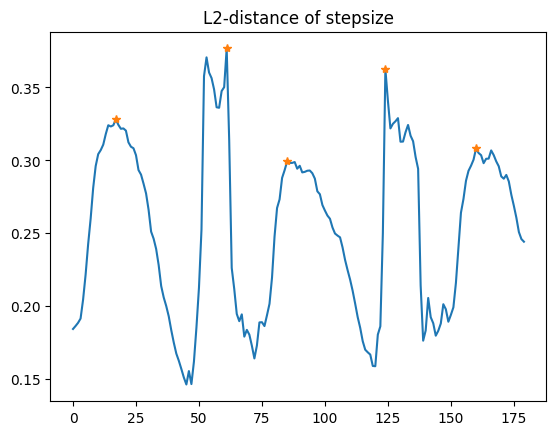

In [38]:
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

# Open the video
cap = cv2.VideoCapture('outputs/PHALP_vid.mp4')
fps = cap.get(cv2.CAP_PROP_FPS)
totalNoFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
durationInSeconds = totalNoFrames // fps
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
cap.release()

local_maxima_indices = argrelextrema(l2_distances,np.greater,order=10)[0]
local_maxima_values = l2_distances[local_maxima_indices]

mean_stride = np.mean(local_maxima_values)

total_number_of_steps = len(local_maxima_indices)

average_steps_per_frame = total_number_of_steps / totalNoFrames

average_steps_per_second = average_steps_per_frame * fps

distance_per_second = average_steps_per_second * mean_stride
km_hour = distance_per_second * 3.6
print(mean_stride, total_number_of_steps, average_steps_per_frame, average_steps_per_second,distance_per_second, km_hour)

plt.title("L2-distance of stepsize")
plt.plot(l2_distances)
plt.plot(local_maxima_indices,local_maxima_values,"*")


In [39]:
import cv2

# Open the video
cap = cv2.VideoCapture('outputs/PHALP_vid.mp4')
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# If you need to convert an entire list of normalized coordinates:
left_ankles_pixels = left_ankles * np.array([width, height])
right_ankles_pixels = right_ankles * np.array([width, height])

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('outputs/PHALP_vid_l2.mp4', fourcc, fps, (width, height))

frame_number = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    if frame_number < len(l2_distances):
        # Draw a line between the left and right ankles
        left_ankle = tuple(map(int, left_ankles_pixels[frame_number]))
        right_ankle = tuple(map(int, right_ankles_pixels[frame_number]))
        cv2.line(frame, left_ankle, right_ankle, (255, 0, 0), 2)

        # Display the L2 distance
        l2_distance = l2_distances[frame_number]
        text = f"L2 distance: {l2_distance:.2f}"
        text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)[0]
        text_x = width - text_size[0] - 10
        text_y = text_size[1] + 10
        cv2.putText(frame, text, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    out.write(frame)
    frame_number += 1

# Release everything when job is finished
cap.release()
out.release()


In [40]:
!ffmpeg -y -hide_banner -loglevel error -i outputs/PHALP_vid_l2.mp4 outputs/PHALP_vid_l2_ffmpg.mp4
show_local_mp4_video('outputs/PHALP_vid_l2_ffmpg.mp4', width=960, height=540)